# Supplementary material – "To Be Defined"
**Submitted to:** International Conference on Service-Oriented Computing (ICSOC) 2025

### General variables, parameters and module imports

> **DISCLAIMER:** This notebook is a part of the supplementary material for the paper "To Be Defined" submitted to International Conference on Service-Oriented Computing (ICSOC) 2025. The notebook is used to analyze the pricing models specified using Pricing2Yaml. The notebook is written in Python and uses multiple libraries for data analysis and visualization. You must install the requirements specified in the `requirements.txt` file to run this notebook.

In [15]:

from matplotlib import pyplot as plt
from IPython.display import display, Markdown
from adjustText import adjust_text
import seaborn as sns
import numpy as np
import pandas as pd
import os
import subprocess
import json


BASE_PATH = os.path.abspath('')
FIGURES_PATH = os.path.join(BASE_PATH, 'figures')
DATA_PATH = os.path.join(BASE_PATH, 'data')

STUDIED_YEARS = ["2019", "2020", "2021", "2022", "2023", "2024", "2025"]

In [16]:
analytics_path = os.path.join(DATA_PATH, 'pricings', 'json')

if not os.path.exists(analytics_path):
    os.makedirs(analytics_path)

# Check if data/json is empty
if not os.listdir(analytics_path):
    subprocess.run(["npm", "install"], check=True)
    subprocess.run(["npx", "ts-node", "src/scripts/analytics/extract-analytics.ts", "-d", "data/pricings/yaml/ICSOC'24"], check=True)
    subprocess.run(["npm", "run", "experiment"], check=True)
    print(f"Experiment completed successfully. You can find the logs in the {os.path.join(BASE_PATH, 'logs')} directory.")
else:
    print(f"The directory {analytics_path} is not empty. Please remove all previously extracted analytics from this directory if you wish to run the experiment and extract the analytics again.")


The directory /Users/alex/Desktop/saas-analysis/data/pricings/json is not empty. Please remove all previously extracted analytics from this directory if you wish to run the experiment and extract the analytics again.


### Generation of Data Frames and Exploratory Analysis

In this section, we focus on the generation of data frames and the initial exploratory analysis of the SaaS pricing data. The data is extracted from the JSON files generated before, and transformed into structured data frames for further analysis. Key metrics such as the number of plans, features, add-ons, and configuration space size will be analyzed across different years. This step is crucial for understanding trends and patterns in the data, which will inform subsequent statistical and comparative analyses.


In [17]:
def build_dataframe(path):
    
    with open(path, 'r') as file:
        data = json.load(file)
        
    records = []
    
    for saas, years_data in data.items():
        for year_data in years_data:
            record = {
                'SaaS': saas,
                'Year': int(year_data['date'].split('-')[0]),
                'Features': year_data['analytics']['numberOfFeatures'],
                'UsageLimits': year_data['analytics']['numberOfUsageLimits'],
                'Plans': year_data['analytics']['numberOfPlans'],
                'Addons': year_data['analytics']['numberOfAddOns'],
                'Configuration_space_size': year_data['analytics']['configurationSpaceSize'],
            }
            
            records.append(record)
            
    df = pd.DataFrame(records, columns=['SaaS', 'Year', 'Features', 'UsageLimits', 'Plans', 'Addons', 'Configuration_space_size'])
    
    return df

# Building the DataFrame
analytics_file = os.path.join(analytics_path, [file for file in os.listdir(analytics_path) if file.endswith("TSC'25.json")][0])
df = build_dataframe(analytics_file)

# Displaying the DataFrame
df

,SaaS,Year,Features,UsageLimits,Plans,Addons,Configuration_space_size
0,Box,2025,64,13,5,5,33
1,Box,2024,50,9,5,0,5
2,Box,2023,50,9,5,0,5
3,Box,2022,50,9,5,0,5
4,Box,2021,46,6,4,0,4
...,...,...,...,...,...,...,...
232,Zoom,2023,134,8,5,14,23296
233,Zoom,2022,108,7,5,10,1600
234,Zoom,2021,55,6,4,8,264
235,Zoom,2020,45,6,4,3,22


In [18]:
if not os.path.exists(os.path.join(DATA_PATH, 'CSVs')):
  os.mkdir(os.path.join(DATA_PATH, 'CSVs'))
# Save the dataframes as CSV
df.to_csv(os.path.join(DATA_PATH, 'CSVs', 'saas_pricingplans.csv'), index=False)

After transforming the JSON file containing all the data into a structured dataframe, its information has been exported as a CSV file, available at the path `data/CSVs/saas_pricingplans.csv` for further use or consultation. 

## Trends in usage limits within SaaS Pricings

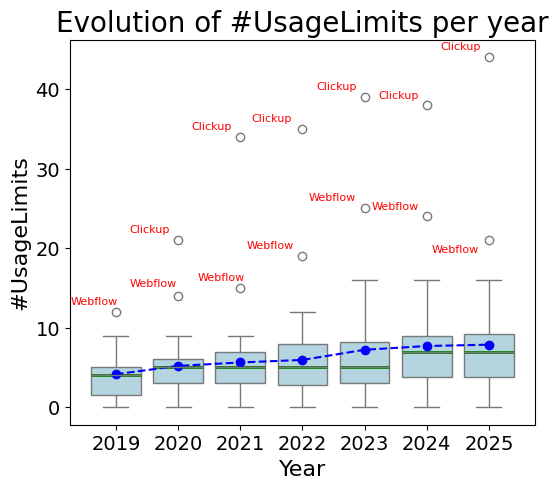

## Mean UsageLimits:

|   Year |   UsageLimits |
|-------:|--------------:|
|   2019 |       4.14815 |
|   2020 |       5.19355 |
|   2021 |       5.62857 |
|   2022 |       5.94444 |
|   2023 |       7.22222 |
|   2024 |       7.69444 |
|   2025 |       7.86111 |

### UsageLimits Increase:

89.50892857142858%

In [20]:
titleSize=20
axisSize=16
fontSize=14
outliersSize=10
plt.rcParams.update({'font.size': fontSize})

def draw_boxplot(field, print_outliers=True, print_mean=True, title=None, y_label=None, tag="a"):
    plt.figure(figsize=(6, 5))
    sns.boxplot(x='Year', y=field, data=df, showfliers=print_outliers, color="lightblue")
    # Add green lines to show the median of each box
    medians = df.groupby('Year')[field].median()
    for i, (year, median) in enumerate(medians.items()):
        plt.hlines(y=median, xmin=i - 0.4, xmax=i + 0.4, color='green', linewidth=2)
    texts = []
    # Adding SaaS to outliers
    for year in df['Year'].unique():
        year_data = df[df['Year'] == year]
        q1 = year_data[field].quantile(0.25)
        q3 = year_data[field].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        if (print_outliers):
            outliers = year_data[(year_data[field] < lower_bound) | (year_data[field] > upper_bound)]
        else:
            outliers = pd.DataFrame()
        
        for idx, row in outliers.iterrows():
            texts.append(plt.gca().text(row['Year']-2019.1, row[field], row['SaaS'], horizontalalignment='right', fontsize=8, color='red'))
    adjust_text(texts, expand=(1.2, 2)) 

    # Calculate means and add line showing its evolution
    means = df.groupby('Year')[field].mean()
    if print_mean:
        plt.plot(means.index-2019, means.values, color='blue', marker='o', linestyle='--', label='Mean')


    if title is None:
        plt.title(f'({tag}) Evolution of #{field} per year', fontsize=titleSize)
    else:
        plt.title(title, fontsize=titleSize)
    plt.suptitle('')
    plt.xlabel('Year', fontsize=axisSize)
    if y_label is None:
        plt.ylabel(f'#{field}',fontsize=axisSize)
    else:
        plt.ylabel(y_label,fontsize=axisSize)
    plt.savefig(os.path.join(FIGURES_PATH,f"SaaS_{field}_Distribution_Evolution.png"), format='png', dpi=300)
    plt.show()
    display(Markdown(f"## Mean {field}:"))
    display(Markdown(means.to_markdown()))
    display(Markdown(f"### {field} Increase:"))
    display(Markdown(str((means[int(STUDIED_YEARS[-1])]/means[int(STUDIED_YEARS[0])] -1)*100)+"%"))

draw_boxplot('UsageLimits', title=f"Evolution of #UsageLimits per year")

The following conclusions can be drawn from the boxplots:

- **Features growing rate**. The results show a linear increase in the number of features over the years. From 2019 to 2025, the average number of features of the SaaS under study has increased by 98\% (from 35.81 to 70.86).

- **Evolution of the numbers of plans**. The number of plans has shown a relatively stable trend from 2019 to 2025, with the number of plans hovering around three to four (the mean increase between 2019 and 2025 is 14\%). While there are occasional outliers, such as *Webflow*, the overall distribution does not show significant increases or decreases in the number of plans offered. This suggests that while some SaaS providers may experiment with the number of plans, the general approach across the industry has remained consistent in terms of the number of plans available to customers. The reason for this tendency might be the Paradox of Choice, as keeping a reduced number of plans facilitates the decision of the customer. 

- **Evolution of the number of add-ons**. SaaS pricings show a clear trend toward incorporating more add-ons, with projections suggesting a continued linear increase. Between 2019 and 2025, the average number of add-ons grew by 211.84\% (from 1.41 to 4.39), reflecting a shift in pricing strategies. This rise can be explained by the fact that add-ons allow for greater configurability without inducing the Paradox of Choice. Consequently, as depicted in the boxplot that illustrates the evolution of the configuration space size, this expansion has led to an exponential growth in the configuration space, empirically validating our formulation of its size (in the paper). Furthermore, the 2025 median configuration space size surpasses the third quartile threshold of 2019, reinforcing the idea of a market-wide transformation in SaaS pricing design.

# Statistical tests

We compare if there are significant differences in the numer of features, plans and addons in the whole set of SaaS among the extreme years of the study (2019 and 2024).

In [11]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene

# Filter data for 2019 and 2025
df_2019 = df[df['Year'] == int(STUDIED_YEARS[0])]
df_2025 = df[df['Year'] == int(STUDIED_YEARS[-1])]

# Compare UsageLimits
usagelimits_2019 = df_2019['UsageLimits'].dropna()
usagelimits_2025 = df_2025['UsageLimits'].dropna()

# Normality Test:
normal_usagelimits_2019 = shapiro(usagelimits_2019).pvalue > 0.05
normal_usagelimits_2025 = shapiro(usagelimits_2025).pvalue > 0.05

# Homoscedasticity (Variance homogeneity) test:
equal_var_usagelimits = levene(usagelimits_2019, usagelimits_2025).pvalue > 0.05

# T Student or Mann-Withney U tests:
if normal_usagelimits_2019 and normal_usagelimits_2025 and equal_var_usagelimits:
    usagelimits_stat, usagelimits_pvalue = ttest_ind(usagelimits_2019, usagelimits_2025)
else:
    usagelimits_stat, usagelimits_pvalue = mannwhitneyu(usagelimits_2019, usagelimits_2025)

print("            p-value")
print(f"UsageLimits:   {usagelimits_pvalue:.6f}")

            p-value
UsageLimits:   0.021919


This code compares the usage limits between 2019 and 2025 to see if there are statistically significant differences using the appropriate test depending on normality and homogeneity of variances.

**The test has shown statistically significant differences** (all p-values are < 0.05), and differences between years 2019 and 2025 in addons and features were very strongly significant.

Next we compute effect size estimators. To calculate the effect size of the differences between 2019 and 2025, we can use Cohen's d for the Student's t-test (data following a normal distribution with homogeneous variance) and the r statistic for the Mann-Whitney U test (data that does not follow a normal distribution or with heterogeneous variance).

In [12]:
# Function for computing Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.var(x) + (ny - 1) * np.var(y)) / dof)

if normal_usagelimits_2019 and normal_usagelimits_2025 and equal_var_usagelimits: 
    usagelimits_effect_size = cohen_d(usagelimits_2019, usagelimits_2025)
    usagelimits_estimator = "Cohen' s d:"
else:    
    usagelimits_effect_size = usagelimits_stat / np.sqrt(len(usagelimits_2019) * len(usagelimits_2025))
    usagelimits_estimator = "r:"

('UsageLimits',usagelimits_estimator,usagelimits_effect_size)

('UsageLimits', 'r:', np.float64(10.312117308025815))

In [ ]:
(equal_var_usagelimits, normal_usagelimits_2019, normal_usagelimits_2025)

(np.True_, np.True_, np.False_)


The effect size values computed in the analysis provide a measure of the magnitude of the differences between the two groups (2019 and 2025) for features, plans, and addons. Here is how to interpret these values:

#### Cohen's d (for t-tests)

Cohen's d is used to measure the effect size for t-tests. The interpretation of Cohen's d values is as follows:

* 0.2: Small effect size
* 0.5: Medium effect size
* 0.8: Large effect size
* A larger Cohen's d indicates a greater difference between the means of the two groups.

#### r (for Mann-Whitney U tests)
The effect size r for the Mann-Whitney U test is interpreted similarly to correlation coefficients:

* 0.1: Small effect size
* 0.3: Medium effect size
* 0.5: Large effect size
* A larger r indicates a greater difference between the distributions of the two groups.

> **WARNING:** In our results, the coefficient of the r estimator is multiplied by 10 to facilitate the interpretation of the results.

### Practical Interpretation
**Features Effect Size:**

Since the effect size is above 0.5 (r estimator is used), the difference is large.


**Plans Effect Size:**

Since the effect size is above 0.5 (r estimator is used), the difference is large.

**Addons Effect Size:**

Since the effect size is above 0.5 (r estimator is used), the difference is large.


These effect sizes help us understand not just whether there is a statistically significant difference, but also the practical significance of the difference. A statistically significant result with a small effect size may indicate that while the difference is real, it is not very impactful in practical terms. Conversely, a large effect size indicates a meaningful difference that could have strong practical implications.